In [4]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext nb_black
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from skimage.metrics import peak_signal_noise_ratio 
import cnnbin
from cnnbin.utils import psnr
from cnnbin.utils import clipto8bit




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Color image
example of training on one image the whole view at once. Note; in this example only the image itself is used to train the network.

In [5]:
sigma = 50
image_ref = imageio.imread("data/monarch.bmp")
image = image_ref + sigma * np.random.standard_normal(image_ref.shape)

binned_ref = np.mean(cnnbin.split_diagonal_rgb(image_ref), 0)
binned_mean = np.mean(cnnbin.split_diagonal_rgb(image), 0)

print(f"Image of shape {image.shape}")

Image of shape (512, 768, 3)


<IPython.core.display.Javascript object>

###  Train on random subsamples

In [ ]:
net = cnnbin.CNNbin(multichannel=True, depth=4, start_filts=48)
net.train_random(image, samples=8, num_epochs=100, learning_rate=3e-4, alpha=0.95)
net.plot_train()
image_filter = clipto8bit(net.filter(image))
plt.figure(figsize=(13, 5))
for i, im in enumerate([binned_mean, image_filter]):
    plt.subplot(1, 2, 1 + i)
    plt.imshow(np.clip(im / 255.0, 0, 1))
    plt.title(f"PSNR {peak_signal_noise_ratio(binned_ref,im,data_range=255):.2f}")
    plt.xticks([])
    plt.yticks([])

Image of shape (512, 768)


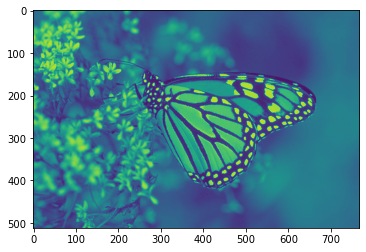

<IPython.core.display.Javascript object>

In [8]:
sigma = 50
image_ref = np.mean(imageio.imread("data/monarch.bmp"), 2)
image = image_ref + sigma * np.random.standard_normal(image_ref.shape)

binned_ref = np.mean(cnnbin.split_diagonal(image_ref), 0)
binned_mean = np.mean(cnnbin.split_diagonal(image), 0)

print(f"Image of shape {image.shape}")
plt.imshow(image_ref)

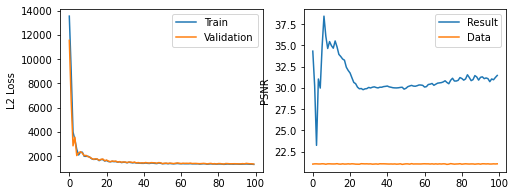

<IPython.core.display.Javascript object>

In [9]:
net = cnnbin.CNNbin(multichannel=False, depth=4, start_filts=48)
net.train_random(image, samples=8, num_epochs=100, learning_rate=3e-4, alpha=0.95)
net.plot_train()

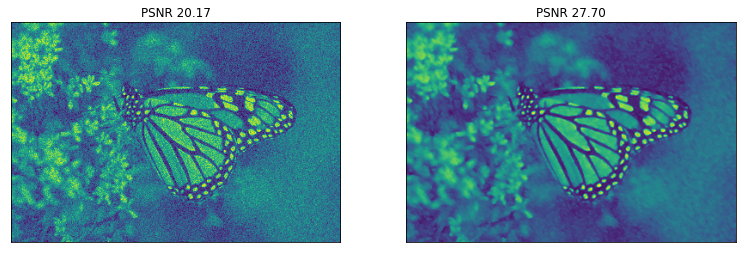

<IPython.core.display.Javascript object>

In [10]:
image_filter = clipto8bit(net.filter(image))
plt.figure(figsize=(13, 5))
for i, im in enumerate([binned_mean, image_filter]):
    plt.subplot(1, 2, 1 + i)
    plt.imshow(np.clip(im / 255.0, 0, 1))
    plt.title(f"PSNR {peak_signal_noise_ratio(binned_ref,im,data_range=255):.2f}")
    plt.xticks([])
    plt.yticks([])

### Batch
Network can also be trained on a list of images
Filtered image has to have sizes%2==0  but patch based training can be done on odd-shaped images aswell.

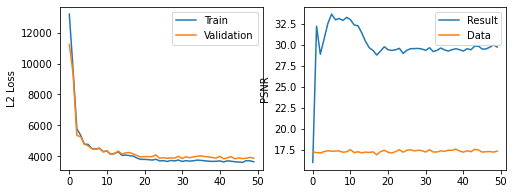

<IPython.core.display.Javascript object>

In [12]:
sigma = 80
images_ref = [
    imageio.imread(x)
    for x in ["data/barbara.bmp", "data/monarch.bmp", "data/comic.bmp"]
]
images = [x + sigma * np.random.standard_normal(x.shape) for x in images_ref]

block_size = (128, 128)
net = cnnbin.CNNbin(multichannel=True, depth=4, start_filts=48, block_size=block_size)
net.train_list(images, num_epochs=50, samples=5, learning_rate=1e-3, alpha=0.99)
net.plot_train()

### Patches
Large images can be trained by either random subpatches or deterministic splitting into fusable subimages. Fusing is done by weighted averaging after applying a window funtion.


In [13]:
block_size = (128,128)
net = cnnbin.CNNbin(multichannel = True, depth=4, start_filts=48, block_size = block_size, batch_size=4)


<IPython.core.display.Javascript object>

In [22]:
image_ref = imageio.imread("data/comic.bmp")[:-1, :, :]
image = image_ref + sigma * np.random.standard_normal(image_ref.shape)
binned_mean = np.mean(cnnbin.split_diagonal_rgb(image), 0)


<IPython.core.display.Javascript object>

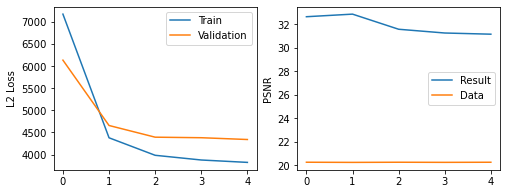

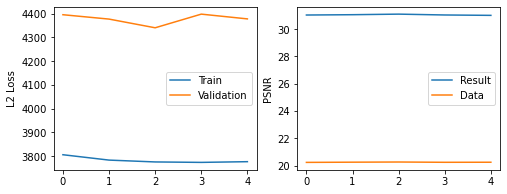

<IPython.core.display.Javascript object>

In [24]:
block_size = (512, 512)
net.train_random(image, num_epochs=5, samples=100, learning_rate=1e-3, alpha=0.99)
net.plot_train()
net.train_random(image, num_epochs=5, samples=100, learning_rate=1e-4, alpha=0.99)
net.plot_train()

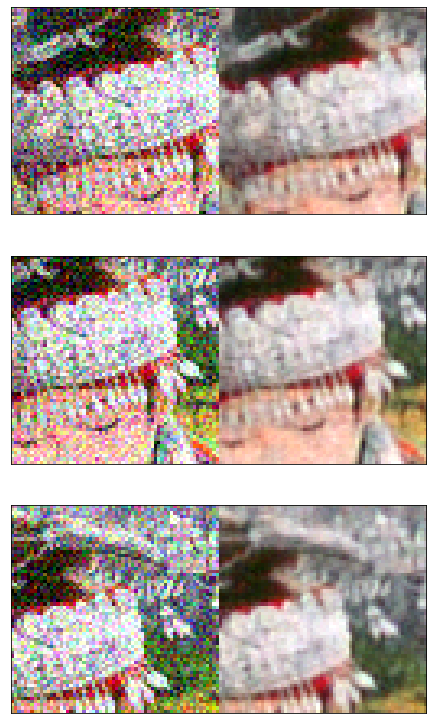

<IPython.core.display.Javascript object>

In [25]:
from cnnbin.utils import random_patches

image_filter = net.filter(image, sampling=1.1)

block_size = (64, 64)
n_patches = 3
seed = 3421
ref = random_patches(binned_mean, block_size, n_patches, seed)
filtered_random = random_patches(image_filter, block_size, n_patches, seed)
W = 13
plt.figure(figsize=(W, n_patches * W / 3))
for i in range(n_patches):
    plt.subplot(n_patches, 1, 1 + i)
    plt.imshow(
        np.concatenate(
            (
                clipto8bit(ref[i]),
                clipto8bit(filtered_random[i]),
            ),
            1,
        )
    )
    plt.xticks([])
    plt.yticks([])